In [66]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/srikarpoladi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [67]:
finviz_url = "https://finviz.com/quote.ashx?t="
tickers = ["AMZN", "NVDA", "META"]

news_tables = {}

for ticker in tickers:
    url = finviz_url+ticker

    req = Request(url=url, headers={"user-agent":'my-app'})
    response = urlopen(req)
    
    html = BeautifulSoup(response, features='html.parser')
    
    news_table = html.find(id="news-table")
    news_tables[ticker] = news_table

'''
amzn_data = news_tables["AMZN"]
amzn_rows = amzn_data.findAll("tr")

for index,row in enumerate(amzn_rows):
    title = row.a.text
    timestamp = row.td.text

'''

parsed_data = []

for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'):

        a_tag = row.find('a', class_='tab-link-news')
        
        if a_tag:
            title = a_tag.text
            date_data = row.td.text.split()

            if len(date_data) == 2:
                date = date_data[0]
                time = date_data[1]
            else:
                time = date_data


            parsed_data.append([ticker, date, time, title])
        else:
            # Handle cases where a_tag is None, if necessary
            continue
        
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)["compound"]
df['compound'] = df["title"].apply(f)

df.head()

,ticker,date,time,title,compound
0,AMZN,Today,02:41PM,Earnings Calendar Spotlight: All Eyes On Apple...,0.1779
1,AMZN,Today,[01:32PM],Universal Music Group stock plunges 20% after ...,-0.3818
2,AMZN,Today,[01:30PM],Warner Bros. stock falls after losing 'key' NB...,0.1027
3,AMZN,Today,[01:14PM],Warner Bros. Stock Gets Benched After NBA Loss...,-0.4939
4,AMZN,Today,[11:37AM],"Amazon racing to develop AI chips cheaper, fas...",0.1779


In [68]:
df['date'] = df['date'].apply(lambda x: 'Jul-25-24' if x == 'Today' else x)
df["date"] = pd.to_datetime(df.date).dt.date
df.date

/var/folders/sb/3g822kv954s3d7032z9m7ckh0000gn/T/ipykernel_37294/921691552.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df.date).dt.date


0      2024-07-25
1      2024-07-25
2      2024-07-25
3      2024-07-25
4      2024-07-25
          ...    
295    2024-07-18
296    2024-07-18
297    2024-07-18
298    2024-07-18
299    2024-07-18
Name: date, Length: 300, dtype: object

In [69]:
plt.figure(figsize=(10,8))

mean_df = df.groupby(['ticker','date'])["compound"].mean()
mean_df

ticker  date      
AMZN    2024-07-21    0.200120
        2024-07-22    0.177421
        2024-07-23    0.174821
        2024-07-24    0.198833
        2024-07-25    0.090925
META    2024-07-18    0.116567
        2024-07-19    0.031042
        2024-07-20    0.229275
        2024-07-21    0.027867
        2024-07-22    0.190754
        2024-07-23    0.125213
        2024-07-24    0.037741
        2024-07-25    0.208131
NVDA    2024-07-23    0.257447
        2024-07-24    0.096037
        2024-07-25    0.124207
Name: compound, dtype: float64

<Figure size 1000x800 with 0 Axes>

In [70]:
mean_df = mean_df.unstack()
mean_df

date,2024-07-18,2024-07-19,2024-07-20,2024-07-21,2024-07-22,2024-07-23,2024-07-24,2024-07-25
ticker,,,,,,,,
AMZN,NaN,NaN,NaN,0.200120,0.177421,0.174821,0.198833,0.090925
META,0.116567,0.031042,0.229275,0.027867,0.190754,0.125213,0.037741,0.208131
NVDA,NaN,NaN,NaN,NaN,NaN,0.257447,0.096037,0.124207


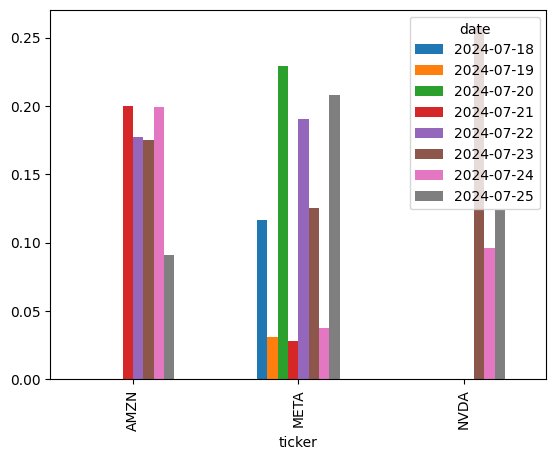

In [71]:
mean_df.plot(kind='bar')
plt.show()